The following websites are critical reference for the code below: \\

[1] Chris McCormick and Nick Ryan, "BERT Fine Tuning Tutorial With Pytorch", Retrieved From https://mccormickml.com/2019/07/22/BERT-fine-tuning/ \\
[2] Google Research, "TensorFlow code and pre-trained models for BERT", Retrieved from https://github.com/google-research/bert \\
[3] Zihang Dai etc, "XLNet: Generalized Autoregressive Pretraining for Language Understanding", Retrieved from: https://github.com/zihangdai/xlnet

In [0]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pandas import DataFrame
import numpy as np
le = LabelEncoder()

In [0]:
# Connect with Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Define trunc function that do the head + tail word truncation for sentences that are longer than 128

def trunc(input_sent):
    truncation = []
    for i, sentence in enumerate(input_sent):
        word_list = sentence.split(' ')
        if len(word_list) > 128:
            new_sent = word_list[0:64]
            new_sent.extend(word_list[-64:-1])
        else:
            new_sent = word_list
        truncation.append(' '.join(new_sent))
    return truncation

BERT requires special format for data inputs: \\
Column 0: An ID for the row \\
Column 1: The label for the row (should be an int) \\
Column 2: A column of the same letter for all rows. BERT wants this so we’ll give it, but we don’t have a use for it. \\
Column 3: The text for the row

In [0]:

# training data location
url = '/content/gdrive/My Drive/data_train.pkl'

raw_data = np.load(url, allow_pickle = True)
data = np.hstack([np.array(raw_data[0])[:, np.newaxis], np.array(raw_data[1])[:, np.newaxis]])
truncation = trunc(raw_data[0])
train_data = pd.DataFrame({'ID':np.arange(data.shape[0]),
                           'label':le.fit_transform(data[:, 1]),
                           'alpha': ['a']*len(data), 
                           'text_example':truncation})
print(train_data.head())


   ID  label alpha                                       text_example
0   0     11     a  Honestly, Buffalo is the correct answer. I rem...
1   1     14     a  Ah yes way could have been :( remember when he...
2   2     12     a  https://youtu.be/6xxbBR8iSZ0?t=40m49s\n\nIf yo...
3   3     16     a  He wouldn't have been a bad signing if we woul...
4   4      9     a  Easy. You use the piss and dry technique. Let ...


In [0]:
# Test data location
url2 = '/content/gdrive/My Drive/data_test.pkl'

raw_test = np.load(url2, allow_pickle = True)
pre_test = trunc(raw_test)
test_data = pd.DataFrame({'ID':np.arange(len(raw_test)), 
                           'text_example':pre_test})
print(test_data.head())

   ID                                       text_example
0   0  Trout and Bryant have both led the league in s...
1   1  &gt; Just like Estonians have good reasons to ...
2   2  Will Sol_Primeval sotp being oblivious?\n\nfin...
3   3  Moving Ostwald borders back to the pre 1967 bo...
4   4         You have to take it out of the bag, Morty!


In [0]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!pip install pytorch-pretrained-bert pytorch-nlp
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 92kB 11.7MB/s 
     |████████████████████████████████| 645kB 48.5MB/s 


Using TensorFlow backend.


'Tesla P100-PCIE-16GB'

In [0]:
sentences = train_data.text_example.values

# add special tokens for BERT to work properly
sentences = ["[CLS] " + query + " [SEP]" for query in sentences]
print(sentences[0])

# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

[CLS] Honestly, Buffalo is the correct answer. I remember people (somewhat) joking that Buffalo's mantra for starting goalies was "win a game, get traded". 
I think Edmonton's front office was a travesty for the better part of 10 years, but Buffalo's systematic destruction of the term 'competitive' was much more responsible for the change to the draft lottery.  [SEP]


100%|██████████| 231508/231508 [00:00<00:00, 5709501.56B/s]


Tokenize the first sentence:
['[CLS]', 'honestly', ',', 'buffalo', 'is', 'the', 'correct', 'answer', '.', 'i', 'remember', 'people', '(', 'somewhat', ')', 'joking', 'that', 'buffalo', "'", 's', 'mantra', 'for', 'starting', 'goal', '##ies', 'was', '"', 'win', 'a', 'game', ',', 'get', 'traded', '"', '.', 'i', 'think', 'edmonton', "'", 's', 'front', 'office', 'was', 'a', 'tr', '##aves', '##ty', 'for', 'the', 'better', 'part', 'of', '10', 'years', ',', 'but', 'buffalo', "'", 's', 'systematic', 'destruction', 'of', 'the', 'term', "'", 'competitive', "'", 'was', 'much', 'more', 'responsible', 'for', 'the', 'change', 'to', 'the', 'draft', 'lottery', '.', '[SEP]']


In [0]:
# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1807 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (611 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1252 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (599 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (605 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length

In [0]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, le.fit_transform(data[:, 1]), 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [0]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=20)
model.cuda()

100%|██████████| 407873900/407873900 [00:08<00:00, 50055738.92B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 1.6181728360373215


Epoch:  33%|███▎      | 1/3 [16:34<33:08, 994.05s/it]

Validation Accuracy: 0.5995053272450532
Train loss: 1.1395711912123185


Epoch:  67%|██████▋   | 2/3 [33:07<16:33, 993.93s/it]

Validation Accuracy: 0.620291095890411
Train loss: 0.8722954496567233


Epoch: 100%|██████████| 3/3 [49:41<00:00, 993.76s/it]

Validation Accuracy: 0.61691400304414


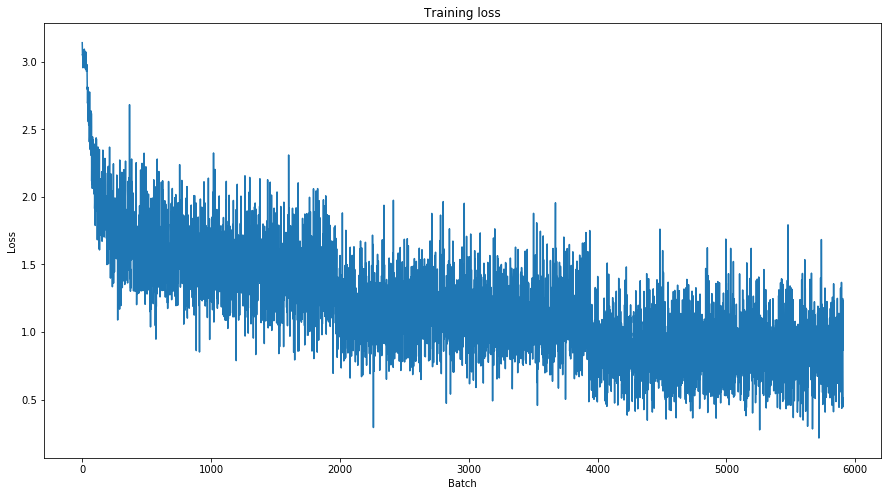

In [0]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 3

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [0]:
# load test data
test_sentences = ["[CLS] " + query + " [SEP]" for query in test_data.text_example.values]
# labels = le.fit_transform(data[:, 1])

# tokenize test data
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# create test tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
# prediction_labels = torch.tensor(labels)
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions = []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask= batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  # label_ids = b_labels.to('cpu').numpy()  
  # Store predictions and true labels
  predictions.append(logits)
  
  
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()


Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (560 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1063 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (602 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (693 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (604 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length 

In [0]:
le.classes_

array(['AskReddit', 'GlobalOffensive', 'Music', 'Overwatch', 'anime',
       'baseball', 'canada', 'conspiracy', 'europe', 'funny',
       'gameofthrones', 'hockey', 'leagueoflegends', 'movies', 'nba',
       'nfl', 'soccer', 'trees', 'worldnews', 'wow'], dtype='<U9834')

In [0]:
label_orig = []
for i in flat_predictions:
    label_orig.append(le.classes_[i])

predict = pd.DataFrame({'Id':np.arange(len(flat_predictions)), 
                        'Category': label_orig})
print(predict.head())

   Id   Category
0   0   baseball
1   1     europe
2   2      anime
3   3  worldnews
4   4      trees


In [0]:
# predicted result named as bert_20191114_epoch3.csv and saved to Google Drive
predict.to_csv('/content/gdrive/My Drive/bert_20191114_epoch3.csv', sep=',', index=False, header=True)